Calculation of Unmixing Coefficients and G Parameter
====================================================
---
_Borys Olifirov, 07.2023_

## Theoretical intro

Based on _Zal and Gascoigne, 2004, doi: 10.1529/biophysj.103.022087_

__Intensity notation__

$$I_{XM(T)}$$

- X - excitation type
- M - emission type
- T - transfection type (A if acceptor only cells), does not present for co-transfected cells


### Sensitized-emission

$$F_c = I_{DA} - a (I_{AA} - c I_{DD}) - d (I_{DD} - b I_{AA})$$

$$F_c = I_{DA} - a I_{AA} - d I_{DD}$$
$$if$$
$$b \approx c \approx 0$$


### Crosstalc caliration

$$a = \frac{I_{DA(A)}}{I_{AA(A)}}$$
$$b = \frac{I_{DD(A)}}{I_{AA(A)}}$$
$$c = \frac{I_{AA(D)}} {I_{DD(D)}}$$
$$d = \frac{I_{DA(D)}} {I_{DD(D)}}$$

$$b \approx c \approx 0$$


### Determination of the G parameter

$$G = \frac{F_c}{I_{DD}^{post} - I_{DD}} = \frac{(I_{DA} - a I_{AA} - d I_{DD}) - (I_{DA}^{post} - a I_{AA}^{post} - d I_{DD}^{post})}{I_{DD}^{post} - I_{DD}}$$


### E-FRET

$$E_{app} = \frac{R}{R+G}, R = \frac{F_c}{I_{DD}}$$

$$E_{corr} = E_{app}(t) \frac{[A^0]_{tot}}{[A^t]_{tot}} = E_{app}(t) \times \frac{\overline{I_{AA}^0 - c I_{DD}^0}}{\overline{I_{AA}(t) - c I_{DD}(t)}}$$

## Script

In [1]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi

### Crosstalk

#### Data uploading

In [2]:
img_path = 'data/crosstalk/'

donor_reg = {'01':[400, 200],  # [exp 435 ms, exp 505 ms]
             '02':[700, 300],
             '03':[500, 400]}
acceptor_reg = {'04':[500, 100],
                '05':[700, 200],
                '06':[500, 300]}

In [3]:
from domb.FRET import coef_calc

calib_reg = coef_calc.CrossRegSet(data_path=img_path,
                             donor_reg_dict = donor_reg,
                             acceptor_reg_dict=acceptor_reg)

In [4]:
abcd_df = calib_reg.get_abcd()
abcd_df

,ID,type,A_exp,D_exp,coef,val,sd
0,04,A,100,500,a,0.175774,0.005592
1,04,A,100,500,b,0.126509,0.005470
2,05,A,200,700,a,0.657202,0.046830
3,05,A,200,700,b,0.456507,0.045130
4,06,A,300,500,a,0.112207,0.014132
5,06,A,300,500,b,0.131851,0.010939
6,01,D,200,400,c,0.216067,0.006042
7,01,D,200,400,d,0.845942,0.002367
8,02,D,300,700,c,0.275591,0.010731
9,02,D,300,700,d,0.869356,0.003092


Concatenation of all coeficients data frames

__a__=0.144+/-0.0318

__b__=0.1292+/-0.0027

__c__=0.2458+/-0.0298

__d__=0.8506+/-0.0138


Vis.

In [5]:
fig = px.box(calib_reg.cross_raw_df, x='coef', y='val', color='ID', points='all')

fig.show()

### G parameter

#### Parameters

In [1]:
a = 0.144
b = 0.1292
c = 0.2458
d = 0.8506

abcd = [a, b, c, d]

tandem_path = 'data/tandem/'

tandem_reg = {'FOV1':['01', '02', 100, 800, 400, 100],  # [raw reg, post reg, bleach frames, bleach exp, 435 exp, 505 exp]
              'FOV2':['03', '04', 100, 800, 400, 200]}

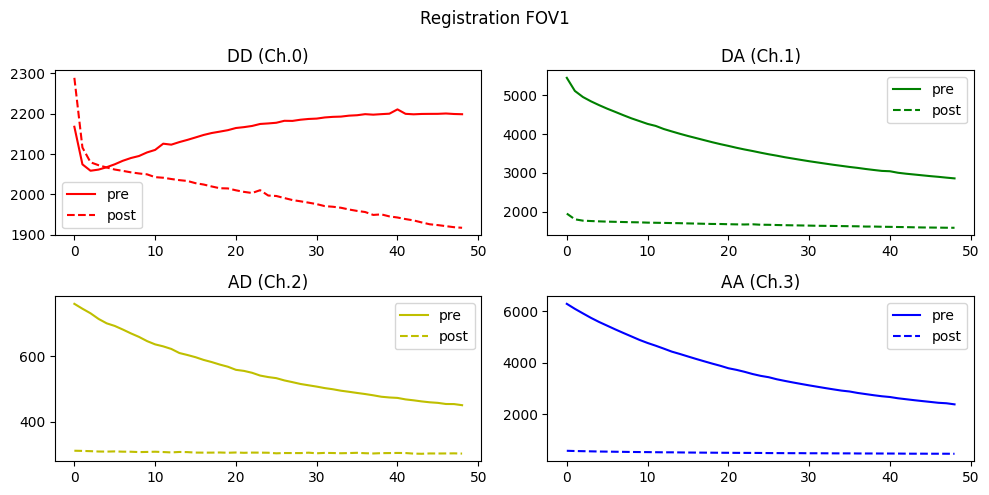

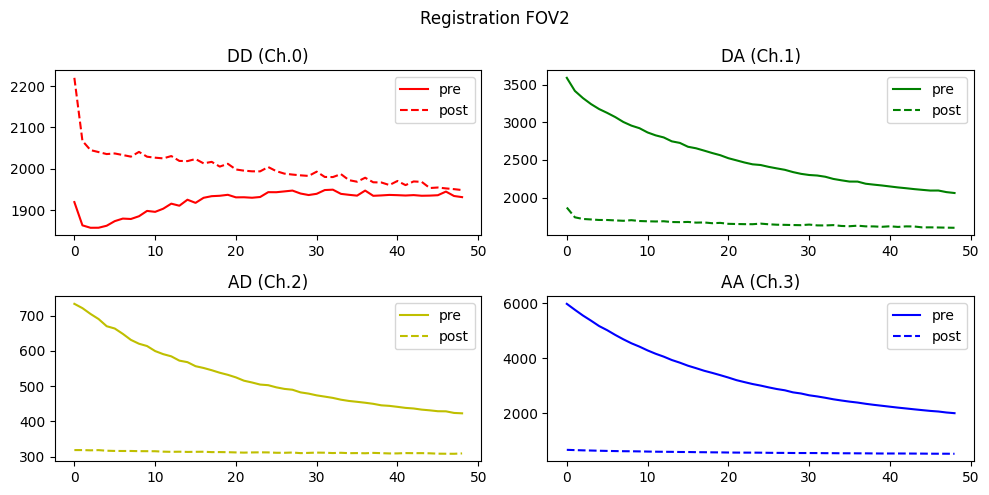

In [3]:
from domb.FRET import coef_calc

G_reg = coef_calc.GRegSet(data_path=tandem_path,
                          tandem_reg_dict=tandem_reg,
                          abcd_list=abcd)
G_df = G_reg.get_G(show_pic=True)

In [4]:
G_df

,ID,A_exp,D_exp,val,sd
0,FOV1,400,100,14.402146,11.777242
1,FOV2,400,200,15.925056,1.251490
